# Does temperature impact the effect of $I_A$ on spike timing?

In [1]:
from common import colors, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ezephys import pltools
from tqdm.notebook import tqdm

from grr import IAmod
from grr.Spiketrain import getSpikeLatency

In [4]:
IMG_PATH = os.getenv('IMG_PATH')
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

# Create toy models

In [5]:
input_strength = 60.2
Vinput = np.empty((10000, 1))
step_index = 3000
burn_index = 2000  # Burn in period in indices
Vinput[step_index:] = input_strength

models = {
    'LIF': IAmod.IAmod(0., 1., 0., 1.),
    'LIF + $I_A$ (RT)': IAmod.IAmod(11.4, 0.545, 0., 1.),
    'LIF + $I_A$ (29C-30C)': IAmod.IAmod(4.54, 0.941, 0., 1.)
}
models['LIF + $I_A$ (29C-30C)'].m_A = 1849.
models['LIF + $I_A$ (29C-30C)'].m_Vhalf = 92.77
models['LIF + $I_A$ (29C-30C)'].m_k = 0.06646
models['LIF + $I_A$ (29C-30C)'].h_A = 1.008
models['LIF + $I_A$ (29C-30C)'].h_Vhalf = -54.93
models['LIF + $I_A$ (29C-30C)'].h_k = -0.1667

for model in models.values():
    model.vreset = -60.

In [6]:
input_strength = 60.2
Vinput = np.empty((10000, 1))
step_index = 0
Vinput[step_index:] = input_strength
dt = 1e-3

latency_data = {k: {'V0': [], 'latency': []} for k in models.keys()}
for V0 in tqdm(np.linspace(-90, -21, 25)):
    for k in models.keys():
        Vinput[:step_index] = models[k].ss_clamp(V0)
        V_mat, spks_mat, _, _ = models[k].simulate(V0, Vinput, dt=dt)
        latency_data[k]['latency'].append(
            getSpikeLatency(
                spks_mat.flatten().astype(np.float16),
                step_index * dt,
                threshold=0.5,
                dt=dt,
            )
        )
        latency_data[k]['V0'].append(V0)

  0%|          | 0/25 [00:00<?, ?it/s]

Saving svg
Saving png
Done!


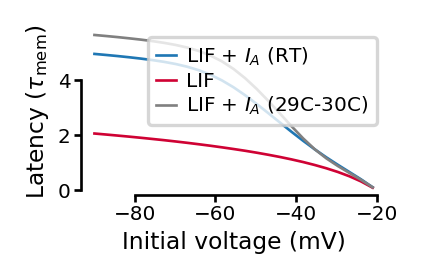

In [7]:
plt.figure(figsize=(1.7, 1))

style = {
    'LIF': {'color': colors['4AP'], 'linestyle': '-'},
    'LIF + $I_A$ (RT)': {'color': colors['ser'], 'linestyle': '-'},
    'LIF + $I_A$ (29C-30C)': {'color': 'gray', 'linestyle': '-'},
}
for k in models.keys():
    plt.plot(
        latency_data[k]['V0'], latency_data[k]['latency'], label=k, **style[k]
    )
plt.xlabel('Initial voltage (mV)')
plt.ylabel(r'Latency ($\tau_\mathrm{mem}$)')
plt.legend()
pltools.hide_border('tr', trim=True)

plt.subplots_adjust(left=0.2, bottom=0.25, top=0.95, right=0.95)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'toy_IA_temp_comparison_absolute_latency'))

Saving svg
Saving png
Done!


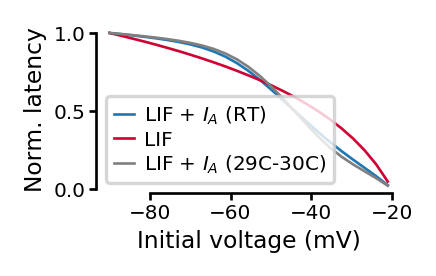

In [8]:
plt.figure(figsize=(1.7, 1))

for k in models.keys():
    plt.plot(
        latency_data[k]['V0'],
        latency_data[k]['latency'] / np.nanmax(latency_data[k]['latency']),
        label=k,
        **style[k]
    )
plt.xlabel('Initial voltage (mV)')
plt.ylabel(r'Norm. latency')
plt.legend()
pltools.hide_border('tr', trim=True)

plt.subplots_adjust(left=0.2, bottom=0.25, top=0.95, right=0.95)

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'toy_IA_temp_comparison_relative_latency'))